# Classification using a Convolutional Neural Network
Group 23 \
Team Member: Jeffrey Wen \
\
First, import the necessary packages

In [2]:
import torch
import torch.nn as nn
import numpy as np
import sklearn.model_selection as model_selection
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt


## Load the data
This code was provided from model_validation.ipynb. There should be 20 features for each sample, 20 classes, and 5000 samples per class.

In [3]:
#Location of the training data
training_folder = 'training_data/'

# instantiate empty arrays for features and labels
Xtr = np.array([])
ytr = np.array([])
k = 0 # initialize

# load data from the relevant files
while True:
    try:
        # load data file
        class_k = np.loadtxt(training_folder + 'Class{:}.csv'.format(k))
        # extract features and labels
        class_k_features = class_k[:,:-1] # extract features
        class_k_labels  = class_k[:,-1].astype(np.int) # labels; convert to int
        
        # append the features and labels to the arrays
        Xtr = np.vstack([Xtr,class_k_features]) if Xtr.size else class_k_features
        ytr = np.hstack([ytr,class_k_labels]) if ytr.size else class_k_labels
        
        # increment counter
        k += 1
    except:
        print('loaded %i classes of training data' %k)
        break

# examine shape
num_classes = k
num_features = Xtr.shape[1]
num_samples = Xtr.shape[0]

print('unique labels: ', np.unique(ytr))
print('number of features: ', num_features)
print('number of samples: ', num_samples)

loaded 20 classes of training data
unique labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
number of features:  20
number of samples:  100000


## Standardize the Data
First, we want to standardize the data. We do this by first finding the sample mean and sample standard deviation for each feature. This prevents the units of the different features from affecting the model. Each feature will have a mean of 0 and variance 1 after the standardization.

In [4]:
#Get the mean and standard deviation of the training data
Xtr_mean = Xtr.mean(axis=0)
Xtr_std = Xtr.std(axis=0)

#Standardize the training data
Xtr_scale = (Xtr - Xtr_mean) / Xtr_std

## Construct the Deep Convolutional Neural Network Class
Here, we define the overall structure of our CNN. We will provide inputs for the number of convolution layers, number of dense layers, kernel size, activation function (['sigmoid','leakyReLU',ReLU']), and options for batch norm and dropout

In [5]:
class Net(nn.Module):
    #Constructor
    def __init__(self,num_conv_layers=3,num_dense_layers=2,kernel_size = 3,nin = 1,num_input_features=20,nout=20,num_channels = 5, activ_func='sigmoid',batch_norm = False, dropout = False):
        #Inherit the initialization of nn.Module
        super(Net,self).__init__()
        
        #Store the choices as elements of the class
        self.batch_norm = batch_norm
        self.dropout = dropout
        
        
        #Set the activation to the user specified activation function
        if activ_func == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activ_func == 'leakyReLU':
            self.activation = nn.LeakyReLU()
        else:
            self.activation = nn.ReLU()
            
        
        #Create an ordered dictionary to store the layers before putting into a sequential NN module
        sequence = OrderedDict([])
        
        #Check track of the input channel for the next layer
        next_num_channels = nin
        
        #Do padding to keep the size of the feature maps
        padding = int((kernel_size - 1)/2)
        
        for i in range(num_conv_layers):
            
            sequence['conv'+str(i)] = nn.Conv1d(next_num_channels,num_channels,kernel_size=kernel_size,padding = padding)
            
            #Add a dropout layer if dropout is true
            if dropout == True:
                sequence['dropout'+str(i)] = nn.Dropout(p=0.5)
                
            #Add a batch norm layer if batch_norm is true
            if batch_norm == True:
                sequence['batchnorm'+str(i)] = nn.BatchNorm1d(num_features = num_channels)
            
            sequence['activation'+str(i)] = self.activation
             
            #Update the next_num_channels
            next_num_channels = num_channels
        
        #All the convolution layers
        self.ConvSequence = nn.Sequential(sequence)
        
        

        #Ordered dictionary for the dense layers
        denseSequence = OrderedDict([])
            
        #Keep track of features into next linear layer
        next_layer_features = int(next_num_channels*num_input_features)
        #Save the number of flat features
        self.num_flat_features = next_layer_features
        
        for i in range(num_dense_layers):
            #Define the layers of the network
            denseSequence['dense'+str(i)] = nn.Linear(next_layer_features,int(next_layer_features//2))
            denseSequence['activation'+str(i)] = self.activation
            next_layer_features = int(next_layer_features//2)
        
        
        #Dense layers
        self.DenseSequence = nn.Sequential(denseSequence)
        
        #Output layer
        self.output = nn.Linear(next_layer_features,nout)
        
    #Define the forward pass
    def forward(self,x):
        #Pass the input through the convolution layers
        x = self.ConvSequence(x)
        
        #Flatten the feature maps
        x = x.view(-1,self.num_flat_features)
        
        #Pass the flattened feature maps into the dense layers
        x = self.DenseSequence(x)
            
        #Get the output
        out = self.output(x)
        return out
        

# Initialize network to make sure it is set up properly
model = Net()

# Print string representation
# print(str(model))
print(str(model))

Net(
  (activation): Sigmoid()
  (ConvSequence): Sequential(
    (conv0): Conv1d(1, 5, kernel_size=(3,), stride=(1,), padding=(1,))
    (activation0): Sigmoid()
    (conv1): Conv1d(5, 5, kernel_size=(3,), stride=(1,), padding=(1,))
    (activation1): Sigmoid()
    (conv2): Conv1d(5, 5, kernel_size=(3,), stride=(1,), padding=(1,))
    (activation2): Sigmoid()
  )
  (DenseSequence): Sequential(
    (dense0): Linear(in_features=100, out_features=50, bias=True)
    (activation0): Sigmoid()
    (dense1): Linear(in_features=50, out_features=25, bias=True)
    (activation1): Sigmoid()
  )
  (output): Linear(in_features=25, out_features=20, bias=True)
)


## Split the data into training and testing data and create dataloaders
We want to perform cross-validation to evaluate how our model will perform on data it was not trained on. We split the dataset into 80% training and 20% testing. Then, to efficiently work with these sets, we create torch dataloaders to handle the batch management of the sets.

In [6]:
#Split the data into testing and training sets with a 20/80 split
X_train,X_test,y_train,y_test = model_selection.train_test_split(Xtr_scale, ytr, test_size = 0.2, shuffle = True)

#Set the batch size for training
batch_size = 100

#Convert the numpy arrays to tensors
Xtr_torch = torch.Tensor(X_train)
ytr_torch = torch.Tensor(y_train)
Xts_torch = torch.Tensor(X_test)
yts_torch = torch.Tensor(y_test)

#Create a training/test dataset from the tensors
train_ds = TensorDataset(Xtr_torch,ytr_torch)
test_ds = TensorDataset(Xts_torch,yts_torch)

#Create a training/test data loader from datasets
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

## Create a function for training the network
We will be perform a cross validation for several hyperparameters of the network, so here we design a general training function that can be easily called during the cross-validation. We also define a function that can be used to evaluate the accuracy on a given set

In [6]:
#Function to evaluate the accuracy of the model on a given set (training or testing)
def evaluate(model,loader):
    #Check the accuracy
    model.eval()
    
    #Keep track of the number of correct predictions
    correct = 0
    total = 0
    
    #If there is a gpu, use the gpu for the training
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        model.to(device)

    with torch.no_grad():
        for data in loader:
            #Split the data for this batch
            xtest,ytest = data
            ytest = ytest.type(torch.long)
            
            #If there is a GPU, move the data to the GPU
            if torch.cuda.is_available():
                xtest = xtest.to(device)
                ytest = ytest.to(device)
            
            #Get the predictions for this batch
            ypred = model(xtest.unsqueeze(1))
            _, predicted = torch.max(ypred.data,dim=1)
            total += ytest.size(0)
            correct += (predicted == ytest).sum().item()
         
    #Return the acuuracy
    accuracy = 100*correct/total
    return accuracy
    

#Function to train the model
def train(model,num_epochs,train_loader, lr, test_loader = None,progression=False):
    
    #Set the optimizer and criterion
    opt = optim.Adam(model.parameters(),lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    #If there is a gpu, use the gpu for the training
    if torch.cuda.is_available():
        print('Using GPU')
        device = torch.device('cuda:0')
        model.to(device)
        
    #Keep track of the training and testing accuracy across epochs
    if progression == True:
        tr_acc = []
        ts_acc = []
    
    for epoch in range(num_epochs):
        
        if progression == True:
            tr_acc.append(evaluate(model,train_loader))
            ts_acc.append(evaluate(model,test_loader))
    
        #Put the model in training mode
        model.train()

        for batch,data in enumerate(train_loader):
            #Get the training data for the batch
            x_batch,y_batch = data
            y_batch = y_batch.type(torch.long)
            
            #If there is a GPU, move the data to the GPU
            if torch.cuda.is_available():
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

            #Make a forward pass
            y_pred = model(x_batch.unsqueeze(1))

            #Compute the loss
            loss = criterion(y_pred,y_batch)

            #Find the gradients and backpropagate
            opt.zero_grad()
            loss.backward()

            #Get an optimization step
            opt.step()
            
            
        


    train_acc = evaluate(model,train_loader)
    
    if progression == True:
        return model, train_acc, tr_acc, ts_acc
    
    
    return model, train_acc

    

## Cross Validation 
We would like to perform cross validation to make better decisions about the hyperparameters to use for the final model. Here, we will train and evaluate the model with different number of hidden nodes, different activations, different learning rates, and the use of batch-norm and dropout. Ideally, we would perform cross-validation for every combination of hyperparameters. However, due to limitations in time and resources, we will perform cross validation for each hyperparameter individually. For the next hyperparameter, we will use the hyperparameters that gave the highest test accuracy from the cross-validation tests before it.

### Cross-Validation for Type of Activation Function


In [7]:
num_epochs = 10

#List of activation functions to try
act_funcs = ['sigmoid','leakyReLU','ReLU']

#Keep track of the train and test accuracies
train_acc = np.zeros(len(act_funcs))
test_acc = np.zeros(len(act_funcs))

for i,act_func in enumerate(act_funcs):
    #Initialize the model
    model = Net(num_conv_layers=3,num_dense_layers=2,kernel_size=3,nin=1,num_input_features=num_features,nout=num_classes,num_channels=5, activ_func=act_func,batch_norm = False, dropout = False)
    
    #Train the model
    model, train_acc[i] = train(model,num_epochs,train_loader,lr=0.001)
    
    #Evaluate the model on the test data
    test_acc[i] = evaluate(model,test_loader)
    
    print('Activation Function: {0},   Training Accuracy: {1:.2f},    Testing Accuracy: {2:.2f}'.format(act_func,train_acc[i],test_acc[i]))
    

Using GPU
Activation Function: sigmoid,   Training Accuracy: 87.27,    Testing Accuracy: 86.58
Using GPU
Activation Function: leakyReLU,   Training Accuracy: 89.87,    Testing Accuracy: 89.15
Using GPU
Activation Function: ReLU,   Training Accuracy: 89.65,    Testing Accuracy: 89.40


Text(0.5, 1.0, 'Testing Accuracy vs. Activation Function')

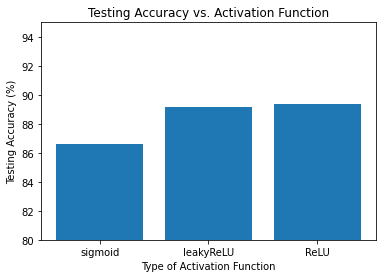

In [8]:
#Plot the testing accuracy of the different activation functions
xvals = []
for i,j in enumerate(act_funcs):
    xvals.append(j)
plt.bar(xvals,test_acc)
plt.ylim(80,95)
plt.xlabel('Type of Activation Function')
plt.ylabel('Testing Accuracy (%)')
plt.title('Testing Accuracy vs. Activation Function')


In [9]:
#Use the activation function with the largest testing accuracy from here on out
act_idx = np.argmax(test_acc)
af = act_funcs[act_idx]
print('Max Accuracy with {0} Activation Function'.format(af))

Max Accuracy with ReLU Activation Function


### Cross Validation for Number of Convolutional Layers

In [10]:
num_epochs = 10

#List of number of conv layers to try
try_values = [1,5,10,20]

#Keep track of the train and test accuracies
train_acc = np.zeros(len(try_values))
test_acc = np.zeros(len(try_values))

for i,val in enumerate(try_values):
    
    #Initialize the model
    model = Net(num_conv_layers=val,num_dense_layers=2,kernel_size = 3,nin = 1,num_input_features=num_features,nout=num_classes,num_channels = 5, activ_func=af,batch_norm = False, dropout = False)

    #Train the model
    model, train_acc[i] = train(model,num_epochs,train_loader,lr=0.001)
    
    #Evaluate the model on the test data
    test_acc[i] = evaluate(model,test_loader)
    
    print('# of Conv Layers: {0:.0f},   Training Accuracy: {1:.2f},    Testing Accuracy: {2:.2f}'.format(val,train_acc[i],test_acc[i]))
    


Using GPU
# of Conv Layers: 1,   Training Accuracy: 89.98,    Testing Accuracy: 89.47
Using GPU
# of Conv Layers: 5,   Training Accuracy: 89.61,    Testing Accuracy: 89.26
Using GPU
# of Conv Layers: 10,   Training Accuracy: 89.97,    Testing Accuracy: 89.34
Using GPU
# of Conv Layers: 20,   Training Accuracy: 4.99,    Testing Accuracy: 5.03


Text(0.5, 1.0, 'Testing Accuracy vs. Number of Conv Layers')

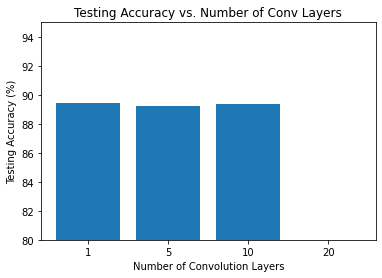

In [12]:
#Plot the testing accuracy of the different number of convolution layers
xvals = []
for i,j in enumerate(try_values):
    xvals.append(str(j))
plt.bar(xvals,test_acc)
plt.ylim(80,95)
plt.xlabel('Number of Convolution Layers')
plt.ylabel('Testing Accuracy (%)')
plt.title('Testing Accuracy vs. Number of Conv Layers')


In [13]:
#Use the number of conv layers with the largest testing accuracy from here on out
val_idx = np.argmax(test_acc)
num_conv_layers = try_values[val_idx]
print('Max Accuracy with {0:.0f} Conv Layer Nodes'.format(num_conv_layers))

Max Accuracy with 1 Conv Layer Nodes


### Cross Validation for Number of Dense Layers


In [14]:
num_epochs = 10

#List of number of dense layers to try
try_values = [1,2,3,4,5]

#Keep track of the train and test accuracies
train_acc = np.zeros(len(try_values))
test_acc = np.zeros(len(try_values))

for i,val in enumerate(try_values):
    
    #Initialize the model
    model = Net(num_conv_layers=num_conv_layers,num_dense_layers=val,kernel_size = 3,nin = 1,num_input_features=num_features,nout=num_classes,num_channels = 5, activ_func=af,batch_norm = False, dropout = False)

    #Train the model
    model, train_acc[i] = train(model,num_epochs,train_loader,lr=0.001)
    
    #Evaluate the model on the test data
    test_acc[i] = evaluate(model,test_loader)
    
    print('# of Dense Layers: {0:.0f},   Training Accuracy: {1:.2f},    Testing Accuracy: {2:.2f}'.format(val,train_acc[i],test_acc[i]))
    

Using GPU
# of Dense Layers: 1,   Training Accuracy: 90.00,    Testing Accuracy: 89.56
Using GPU
# of Dense Layers: 2,   Training Accuracy: 89.89,    Testing Accuracy: 89.23
Using GPU
# of Dense Layers: 3,   Training Accuracy: 89.34,    Testing Accuracy: 88.60
Using GPU
# of Dense Layers: 4,   Training Accuracy: 88.91,    Testing Accuracy: 88.41
Using GPU
# of Dense Layers: 5,   Training Accuracy: 84.40,    Testing Accuracy: 83.76


Text(0.5, 1.0, 'Testing Accuracy vs. Number of Dense Layers')

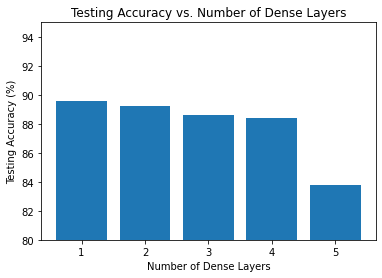

In [15]:
#Plot the testing accuracy of the different number of dense layers
xvals = []
for i,j in enumerate(try_values):
    xvals.append(str(j))
plt.bar(xvals,test_acc)
plt.ylim(80,95)
plt.xlabel('Number of Dense Layers')
plt.ylabel('Testing Accuracy (%)')
plt.title('Testing Accuracy vs. Number of Dense Layers')


In [16]:
#Use the number of dense layers with the largest testing accuracy from here on out
val_idx = np.argmax(test_acc)
num_dense_layers = try_values[val_idx]
print('Max Accuracy with {0:.0f} Dense Layer Nodes'.format(num_dense_layers))

Max Accuracy with 1 Dense Layer Nodes


### Cross Validation for Learning Rate

In [20]:
num_epochs = 10

#List of number of dense layers to try
try_values = [1.0,0.1,0.001,0.0001]

#Keep track of the train and test accuracies
train_acc = np.zeros(len(try_values))
test_acc = np.zeros(len(try_values))

#Keep track of the accuracies across epochs for plotting
train_acc_epochs = np.zeros((len(try_values),num_epochs))
test_acc_epochs = np.zeros((len(try_values),num_epochs))

for i,val in enumerate(try_values):
    
    #Initialize the model
    model = Net(num_conv_layers=num_conv_layers,num_dense_layers=num_dense_layers,kernel_size = 3,nin = 1,num_input_features=num_features,nout=num_classes,num_channels = 5, activ_func=af,batch_norm = False, dropout = False)
    
    #Train the model
    model, train_acc[i], train_acc_epochs[i], test_acc_epochs[i] = train(model,num_epochs,train_loader,lr=val,test_loader=test_loader,progression=True)
    
    #Evaluate the model on the test data
    test_acc[i] = evaluate(model,test_loader)
    
    print('Learning Rate: {0},   Training Accuracy: {1:.2f},    Testing Accuracy: {2:.2f}'.format(val,train_acc[i],test_acc[i]))
    

Using GPU
Learning Rate: 1.0,   Training Accuracy: 4.98,    Testing Accuracy: 5.07
Using GPU
Learning Rate: 0.1,   Training Accuracy: 83.79,    Testing Accuracy: 83.12
Using GPU
Learning Rate: 0.001,   Training Accuracy: 90.27,    Testing Accuracy: 89.44
Using GPU
Learning Rate: 0.0001,   Training Accuracy: 86.88,    Testing Accuracy: 86.47


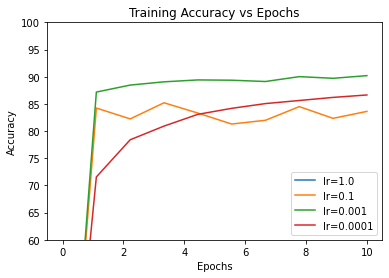

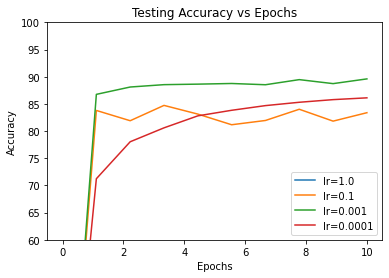

In [21]:
#Plot the progression of the training and testing accuracy across epochs
x = np.linspace(0,num_epochs,num_epochs)
for i,lr in enumerate(try_values):
    plt.plot(x,train_acc_epochs[i],label='lr='+str(lr))
    
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(60,100)
plt.title('Training Accuracy vs Epochs')
plt.legend()

#New figure for testing accuracy
plt.figure()
for i,lr in enumerate(try_values):
    plt.plot(x,test_acc_epochs[i],label='lr='+str(lr))
    
plt.xlabel('Epochs')
plt.ylim(60,100)
plt.ylabel('Accuracy')
plt.title('Testing Accuracy vs Epochs')
plt.legend()

In [22]:
#Use the number of dense layers with the largest testing accuracy from here on out
val_idx = np.argmax(test_acc)
lr = try_values[val_idx]
print('Max Accuracy with {0} Learning Rate'.format(lr))

Max Accuracy with 0.001 Learning Rate


### Cross Validation for Kernel Size

In [23]:
num_epochs = 10

#List of kernels numbers to try
try_values = [1,3,5,7]

#Keep track of the train and test accuracies
train_acc = np.zeros(len(try_values))
test_acc = np.zeros(len(try_values))

for i,val in enumerate(try_values):
    
    #Initialize the model
    model = Net(num_conv_layers=num_conv_layers,num_dense_layers=num_dense_layers,kernel_size = val,nin = 1,num_input_features=num_features,nout=num_classes,num_channels = 5, activ_func=af,batch_norm = False, dropout = False)

    #Train the model
    model, train_acc[i] = train(model,num_epochs,train_loader,lr= lr)
    
    #Evaluate the model on the test data
    test_acc[i] = evaluate(model,test_loader)
    
    print('Kernel Size: {0}x{0},   Training Accuracy: {1:.2f},    Testing Accuracy: {2:.2f}'.format(val,train_acc[i],test_acc[i]))
    

Using GPU
Kernel Size: 1x1,   Training Accuracy: 89.98,    Testing Accuracy: 89.50
Using GPU
Kernel Size: 3x3,   Training Accuracy: 90.33,    Testing Accuracy: 89.75
Using GPU
Kernel Size: 5x5,   Training Accuracy: 90.10,    Testing Accuracy: 89.55
Using GPU
Kernel Size: 7x7,   Training Accuracy: 90.09,    Testing Accuracy: 89.58


Text(0.5, 1.0, 'Testing Accuracy vs. Kernel Size')

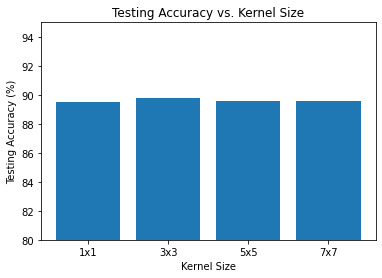

In [24]:
#Plot the testing accuracy of the different kernel
xvals = []
for i,j in enumerate(try_values):
    xvals.append(str(j)+'x'+str(j))
plt.bar(xvals,test_acc)
plt.ylim(80,95)
plt.xlabel('Kernel Size')
plt.ylabel('Testing Accuracy (%)')
plt.title('Testing Accuracy vs. Kernel Size')


In [25]:
#Use the number of kernels with the largest testing accuracy from here on out
val_idx = np.argmax(test_acc)
kernel_size = try_values[val_idx]
print('Max Accuracy with {0}x{0} Kernel Size'.format(kernel_size))

Max Accuracy with 3x3 Kernel Size


### Cross Validation for Number of Channels

In [26]:
num_epochs = 10

#List of channels numbers to try
try_values = [1,3,5,7]

#Keep track of the train and test accuracies
train_acc = np.zeros(len(try_values))
test_acc = np.zeros(len(try_values))

for i,val in enumerate(try_values):
    
    #Initialize the model
    model = Net(num_conv_layers=num_conv_layers,num_dense_layers=num_dense_layers,kernel_size = kernel_size,nin = 1,num_input_features=num_features,nout=num_classes,num_channels = val, activ_func=af,batch_norm = False, dropout = False)
    

    #Train the model
    model, train_acc[i] = train(model,num_epochs,train_loader,lr= lr)
    
    #Evaluate the model on the test data
    test_acc[i] = evaluate(model,test_loader)
    
    
    print('# Channels: {0},   Training Accuracy: {1:.2f},    Testing Accuracy: {2:.2f}'.format(val,train_acc[i],test_acc[i]))

Using GPU
# Channels: 1,   Training Accuracy: 86.07,    Testing Accuracy: 85.83
Using GPU
# Channels: 3,   Training Accuracy: 89.17,    Testing Accuracy: 88.79
Using GPU
# Channels: 5,   Training Accuracy: 90.04,    Testing Accuracy: 89.50
Using GPU
# Channels: 7,   Training Accuracy: 90.68,    Testing Accuracy: 89.97


Text(0.5, 1.0, 'Testing Accuracy vs. Number of Channels')

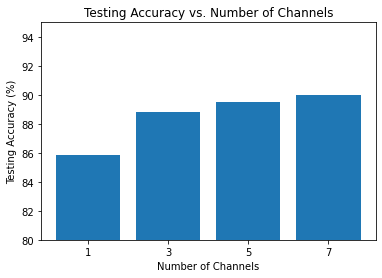

In [27]:
#Plot the testing accuracy of the number of channels
xvals = []
for i,j in enumerate(try_values):
    xvals.append(str(j))
plt.bar(xvals,test_acc)
plt.ylim(80,95)
plt.xlabel('Number of Channels')
plt.ylabel('Testing Accuracy (%)')
plt.title('Testing Accuracy vs. Number of Channels')


In [28]:
#Use the number of channels with the largest testing accuracy from here on out
val_idx = np.argmax(test_acc)
num_channels = try_values[val_idx]
print('Max Accuracy with {0} Channels'.format(num_channels))

Max Accuracy with 7 Channels


learning_rates### Cross Validation for Batch Norm and Dropout

In [29]:
num_epochs = 10

#List of channels to try
try_values = [[True,True],[True,False],[False,True],[False,False]]

#Keep track of the train and test accuracies
train_acc = np.zeros(len(try_values))
test_acc = np.zeros(len(try_values))

for i,val in enumerate(try_values):
    
    #Initialize the model
    model = Net(num_conv_layers=num_conv_layers,num_dense_layers=num_dense_layers,kernel_size = kernel_size,nin = 1,num_input_features=num_features,nout=num_classes,num_channels = num_channels, activ_func=af,batch_norm = val[0], dropout = val[1])

    #Train the model
    model, train_acc[i] = train(model,num_epochs,train_loader,lr= lr)
    
    #Evaluate the model on the test data
    test_acc[i] = evaluate(model,test_loader)
    
    print('Batch Norm: {0},    Dropout: {3},   Training Accuracy: {1:.2f},    Testing Accuracy: {2:.2f}'.format(val[0],train_acc[i],test_acc[i],val[1]))
    

Using GPU
Batch Norm: True,    Dropout: True,   Training Accuracy: 87.10,    Testing Accuracy: 86.59
Using GPU
Batch Norm: True,    Dropout: False,   Training Accuracy: 90.55,    Testing Accuracy: 89.86
Using GPU
Batch Norm: False,    Dropout: True,   Training Accuracy: 88.42,    Testing Accuracy: 87.89
Using GPU
Batch Norm: False,    Dropout: False,   Training Accuracy: 90.79,    Testing Accuracy: 90.00


Text(0.5, 1.0, 'Testing Accuracy vs. Batch Norm and Dropout Additions')

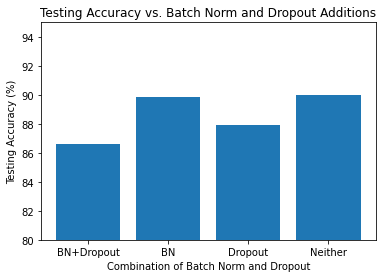

In [30]:
#Plot the testing accuracy of the different inclusions of batch norm and dropout
xvals = ['BN+Dropout', 'BN', 'Dropout', 'Neither']
plt.bar(xvals,test_acc)
plt.ylim(80,95)
plt.xlabel('Combination of Batch Norm and Dropout')
plt.ylabel('Testing Accuracy (%)')
plt.title('Testing Accuracy vs. Batch Norm and Dropout Additions')



In [31]:
#Use the batchnorm and dropout configurations with the largest testing accuracy from here on out
val_idx = np.argmax(test_acc)
BNDP = try_values[val_idx]
print('Max Accuracy with Batch Norm: {0},  Dropout: {1}'.format(BNDP[0],BNDP[1]))

Max Accuracy with Batch Norm: False,  Dropout: False


## Confusion Matrix
For the network with the highest test accuracy, we would like to see the confusion matrix to see what categories the network does well on and which networks it struggles with

In [35]:
#Train the model with the best performing hyperparameters from each of the cross validations
model = Net(num_conv_layers=num_conv_layers,num_dense_layers=num_dense_layers,kernel_size = kernel_size,nin = 1,num_input_features=num_features,nout=num_classes,num_channels = num_channels, activ_func=af,batch_norm = BNDP[0], dropout = BNDP[1])
model, train_acc = train(model,num_epochs,train_loader,lr=lr)

#Evaluate the model on the test data
test_acc = evaluate(model,test_loader)

#Check the confusion matrix
model.eval()

#Initialize the confusion matrix
C = np.zeros((num_classes,num_classes))

#If there is a gpu, use the gpu for the training
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    model.to(device)

with torch.no_grad():
    for data in test_loader:
        #Split the data for this batch
        xtest,ytest = data
        ytest = ytest.type(torch.long)

        #If there is a GPU, move the data to the GPU
        if torch.cuda.is_available():
            xtest = xtest.to(device)
            ytest = ytest.to(device)

        #Get the predictions for this batch
        ypred = model(xtest.unsqueeze(1))
        _, predicted = torch.max(ypred.data,dim=1)

        #Find the performance metrics
        C = C + confusion_matrix(ytest.cpu().numpy(),predicted.cpu().numpy(),labels=np.unique(ytr))



Using GPU


Training Accuracy: 90.57,    Testing Accuracy: 90.08


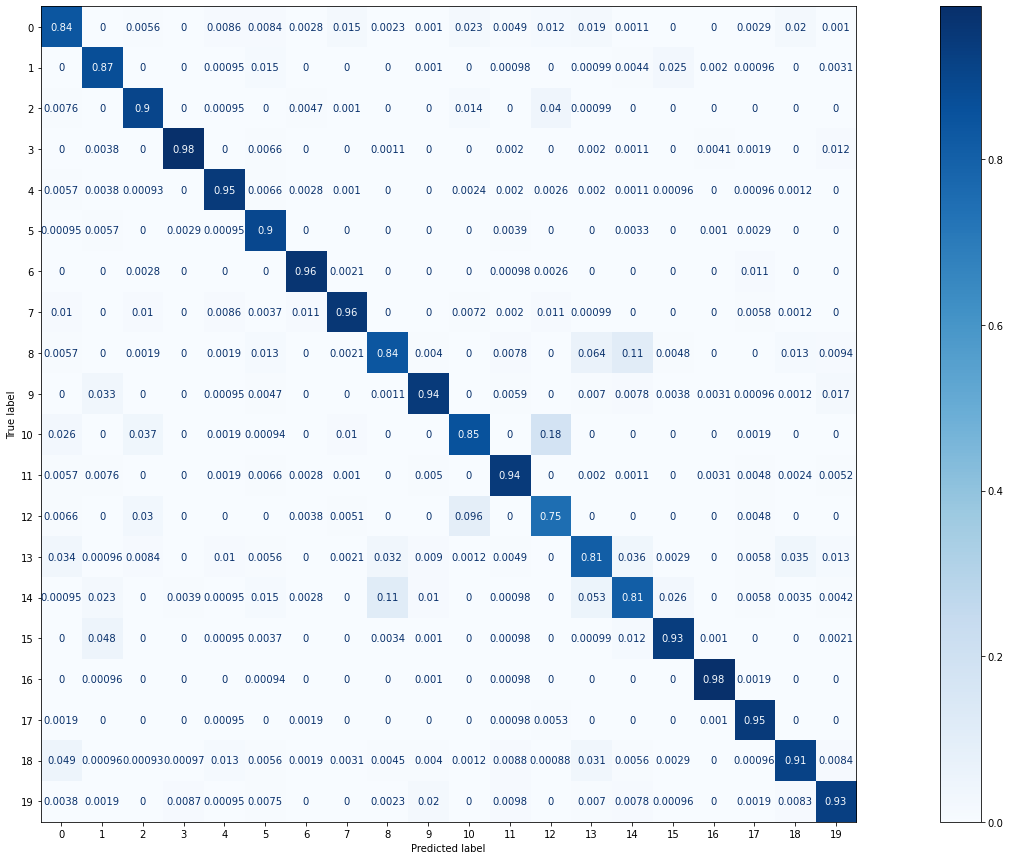

In [36]:
#Normalize the confusion matrix
col_totals= C.sum(axis=0)
C = C/col_totals        
        
#Print the confusion matrix and performance
print('Training Accuracy: {0:.2f},    Testing Accuracy: {1:.2f}'.format(train_acc,test_acc))
#print(np.array_str(C, precision=4, suppress_small=True))
plt.rcParams['figure.figsize'] = [30, 15]
conf_matrix_plot = ConfusionMatrixDisplay(C)
conf_matrix_plot.plot(cmap=plt.cm.Blues)

## Final Network
After using cross-validation to select the hyperparameters, we would like to train a final network using all the training data.

In [9]:
#Convert the numpy arrays to tensors
Xall_torch = torch.Tensor(Xtr_scale)
yall_torch = torch.Tensor(ytr)

#Create a training dataset from the tensors
trainall_ds = TensorDataset(Xall_torch,yall_torch)

#Create a trainingdata loader from dataset
trainall_loader = DataLoader(trainall_ds, batch_size=batch_size, shuffle = True)

#Train the model with the best performing hyperparameters from each of the cross validations
model = Net(num_conv_layers=num_conv_layers,num_dense_layers=num_dense_layers,kernel_size = kernel_size,nin = 1,num_input_features=num_features,nout=num_classes,num_channels = num_channels, activ_func=af,batch_norm = BNDP[0], dropout = BNDP[1])
model, train_acc = train(model,num_epochs,trainall_loader,lr=lr)

#Show final training accuracy
print('Training Accuracy with all Training Data: {0:.2f}'.format(train_acc))


#Save the pytorch model by saving the trace with a random input
x = torch.randn(num_features) # random input
x = x[None,:] # add singleton batch index
#if torch.cuda.is_available():
#    x = x.to(device)
 
with torch.no_grad():
    traced_cell = torch.jit.trace(model, (x.unsqueeze(1)))
torch.jit.save(traced_cell, "./saved_model_CNN.pth")

#Check to make sure the save gives the same output
# original model:
with torch.no_grad():
    out = model(x.unsqueeze(1))
print(out)

# reloaded model:
model2 = torch.jit.load("./saved_model_CNN.pth")
with torch.no_grad():
    out2 = model2(x.unsqueeze(1))
print(out2)

tensor([[-17.7819,   0.9138, -36.4594,  -6.7785,  -8.5294,   3.3948, -32.5571,
         -31.9154,  -0.0755,   0.5020, -15.4854, -16.6465, -37.5014,   6.1937,
           6.9160,   2.3968,  -7.6776, -29.4571,  -7.3400,   1.8783]])
tensor([[-17.7819,   0.9138, -36.4594,  -6.7785,  -8.5294,   3.3948, -32.5571,
         -31.9154,  -0.0755,   0.5020, -15.4854, -16.6465, -37.5014,   6.1937,
           6.9160,   2.3968,  -7.6776, -29.4571,  -7.3400,   1.8783]])
